## Import

In [1]:
%env TF_CPP_MIN_LOG_LEVEL=3
import json
import pathlib
import sys
from pprint import pprint

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom as pdc
import tensorflow as tf

sys.path.append(pathlib.Path.cwd().parent.as_posix())
import numpy as np
import tensorflow as tf
from keras.utils.layer_utils import count_params
from matplotlib import pyplot as plt

from src.data.preprocess.lib.tfrecord import parsed_example_fn
from src.data.preprocess.lib.utils import convert_num_to_abr, string_to_int_tuple
from src.models.lib.base import base_unet_pp
from src.models.lib.builder import build_unet_pp
from src.models.lib.config import UNetPPConfig
from src.models.lib.data_loader import preprocess_img
from src.models.lib.loss import (
    categorical_focal_loss,
    dice_coef_func,
    dice_coef_with_bg,
    dice_focal,
    weighted_categorical_crossentropy,
)
from src.models.lib.utils import loss_dict_gen
from src.models.train_model import create_dataset

env: TF_CPP_MIN_LOG_LEVEL=3


## Model Loading

In [2]:
project_root_path = pathlib.Path.cwd().parent
model_root_path = project_root_path / "models" / "cloud" / "models"/ "mini_tr_dice_focal_def-2023-06-11T11:08:57.813149"
model_paths = list(
    (model_root_path).rglob(
        "*model*"
    )
)
model_paths

[PosixPath('/home/adit/projects/uni/mobile-unetplusplus-cac-scoring/models/cloud/models/mini_tr_dice_focal_def-2023-06-11T11:08:57.813149/model-epoch-01.h5'),
 PosixPath('/home/adit/projects/uni/mobile-unetplusplus-cac-scoring/models/cloud/models/mini_tr_dice_focal_def-2023-06-11T11:08:57.813149/best-model-epoch-01.h5'),
 PosixPath('/home/adit/projects/uni/mobile-unetplusplus-cac-scoring/models/cloud/models/mini_tr_dice_focal_def-2023-06-11T11:08:57.813149/model-epoch-03.h5'),
 PosixPath('/home/adit/projects/uni/mobile-unetplusplus-cac-scoring/models/cloud/models/mini_tr_dice_focal_def-2023-06-11T11:08:57.813149/model-epoch-02.h5')]

In [3]:
selected_model_path = model_paths[2].as_posix()
float_model = tf.keras.models.load_model(
    selected_model_path,
    custom_objects={
        "loss": dice_focal(),
        "dice_coef": dice_coef_func(use_bg=False),
        "dice_coef_with_bg": dice_coef_with_bg,
    },
)

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [4]:
# Model conversion from mixed precision to float32
model = tf.keras.models.clone_model(
    float_model,
    clone_function=lambda layer: layer.__class__.from_config(
        {**layer.get_config(), "dtype": "float32"}
    ),
)

## Sample Loading

Patient 3 Image 2/4 (042)
/home/adit/projects/uni/mobile-unetplusplus-cac-scoring/data/raw/cocacoronarycalciumandchestcts-2/Gated_release_final/patient/3/Pro_Gated_CS_3.0_I30f_3_70%/IM-6060-0042.dcm
LAD
LCX


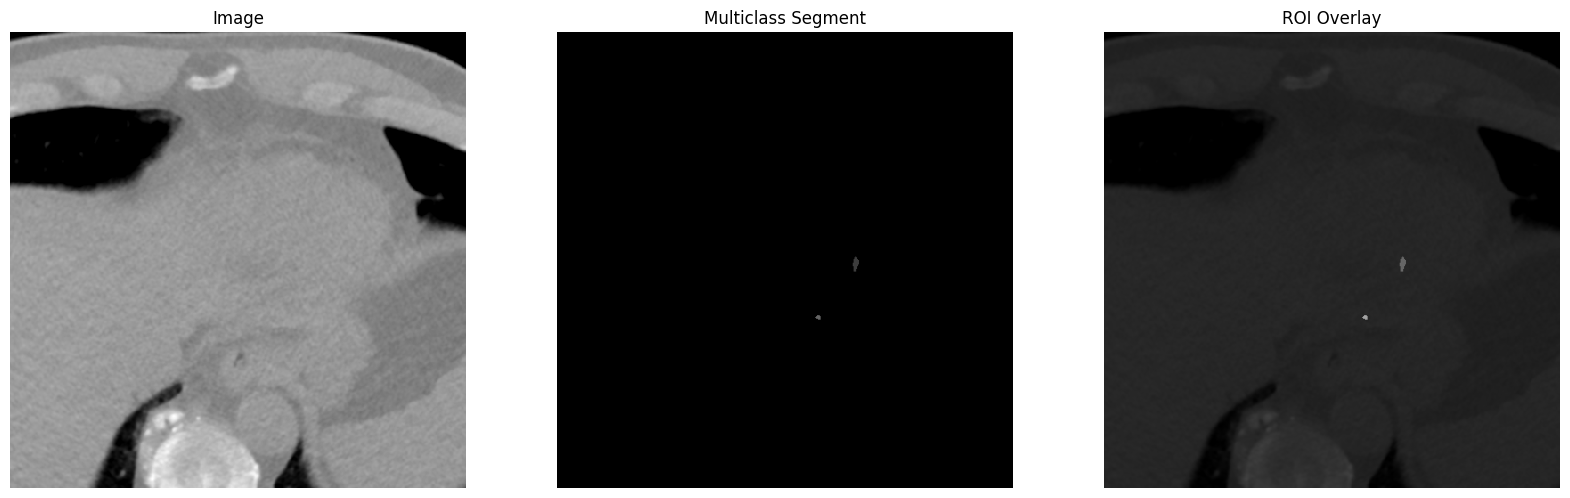

In [5]:
project_root_path = pathlib.Path.cwd().parent

patient_idx = 3
patient_img_idx = 1
clean_json_path = list(project_root_path.rglob("clean*.json"))[0]

with clean_json_path.open(mode="r") as json_file:
    clean_dict_output = json.load(json_file)

patient_info = clean_dict_output[str(patient_idx).zfill(3)]


patient_img_info = patient_info[patient_img_idx]

patient_img_num = patient_img_info["idx"]

print(
    f"Patient {patient_idx} Image {patient_img_idx+1}/{len(patient_info)} ({patient_img_num})"
)

patient_root_path = next(project_root_path.rglob(f"patient/{patient_idx}"))
patient_dcm_path = next(
    patient_root_path.rglob(f"*00{str(patient_img_num).lstrip('0').zfill(2)}.dcm")
)
print(patient_dcm_path)
patient_dcm = pdc.dcmread(patient_dcm_path)
patient_img_arr = patient_dcm.pixel_array
patient_img_hu = pdc.pixel_data_handlers.util.apply_modality_lut(
    patient_img_arr, patient_dcm
)

patient_img_hu_pre = preprocess_img(patient_img_hu)

patient_roi = patient_img_info["roi"]
plot_dict = {}

for roi in patient_roi:
    vessel_loc = roi["loc"]
    vessel_pos = plot_dict.get(vessel_loc, [])
    vessel_pos.extend(roi["pos"])
    plot_dict[vessel_loc] = vessel_pos

plot_dict_fig, ax = plt.subplots(1, 3,figsize=(20,60))

ax[0].set_title("Image")
ax[0].axis("off")
ax[0].imshow(patient_img_hu_pre, cmap="gray", interpolation="none")

ax[1].set_title("Multiclass Segment")

ax[1].imshow(np.ones([512, 512]), cmap="gray")

for loc, p in plot_dict.items():
    temp = np.zeros((512, 512))
    temp[tuple(zip(*p))] = 1
    ax[1].axis("off")
    ax[1].imshow(np.transpose(temp), cmap="gray", alpha=0.4)

ax[2].set_title("ROI Overlay")
ax[2].axis("off")
ax[2].imshow(patient_img_hu_pre, cmap="gray", interpolation="none")
for loc, p in plot_dict.items():
    temp = np.zeros((512, 512))
    temp[tuple(zip(*p))] = 1
    ax[2].imshow(np.transpose(temp), cmap="gray", alpha=0.5)
    print(loc)

# plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

plt.show()

## Model Prediction

In [6]:
expanded_sample_img_hu = np.expand_dims(
    np.expand_dims(patient_img_hu_pre, axis=0), axis=3
)

In [7]:
float_output = float_model.predict(expanded_sample_img_hu)
output = model.predict(expanded_sample_img_hu)

1/1 [==============================] - 15s 15s/step


### Multiclass Seg

0 null 0.0
0 LAD 3583.0
0 RCA 155.0
0 LCX 2433.0
0 LCA 255973.0
1 null 786.0
1 LAD 180.0
1 RCA 259799.0
1 LCX 327.0
1 LCA 1052.0
2 null 39.0
2 LAD 253650.0
2 RCA 3283.0
2 LCX 23.0
2 LCA 5149.0
3 null 7745.0
3 LAD 158846.0
3 RCA 18071.0
3 LCX 103.0
3 LCA 77379.0


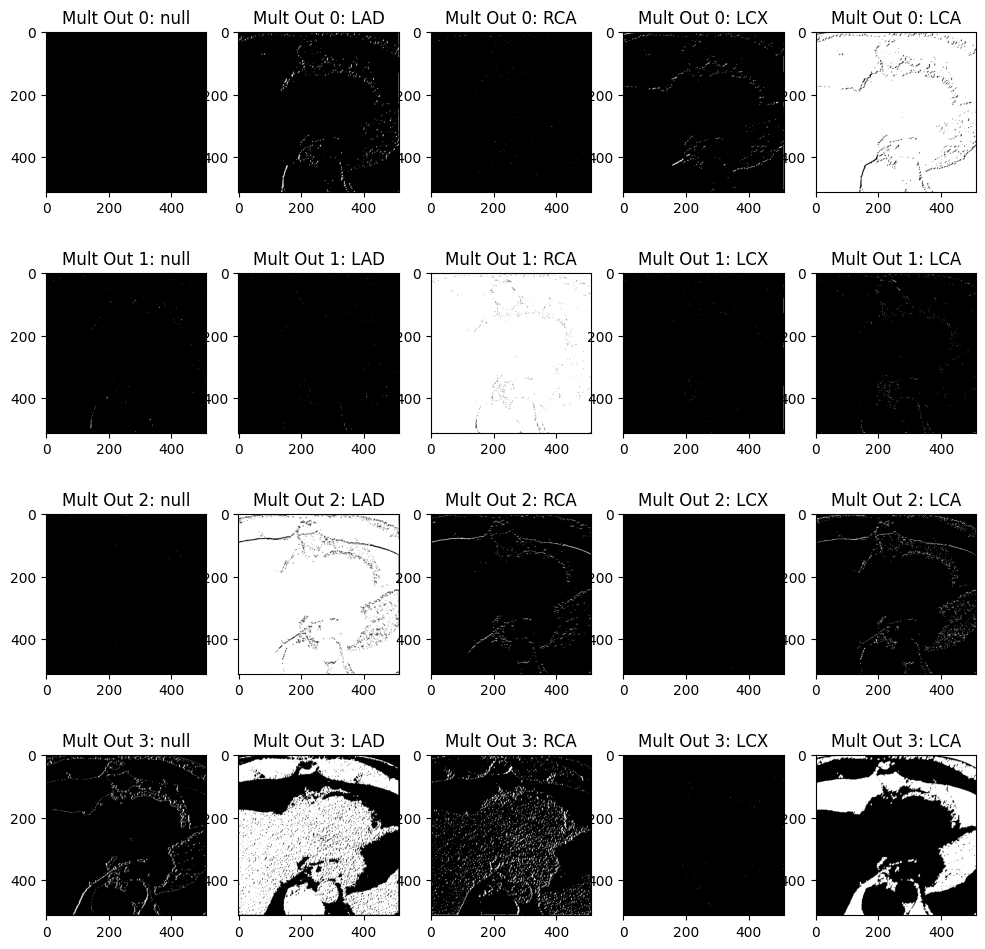

In [8]:
raw_mult_output = []
clipped_mult_output = []
mult_roi_coord = []
fig, ax = plt.subplots(4, 5, figsize=(12, 12))

for e, i in enumerate(range(4)):
    raw_mult_output.append(np.squeeze(output[i]))
    argmax = tf.argmax(raw_mult_output[e], axis=2)
    one_hot = tf.one_hot(argmax, depth=5, dtype=tf.float32)
    clipped_mult_output.append(one_hot)
    mult_roi_coord.append(np.where(clipped_mult_output[e] == 1))
    for pi, t in zip(range(5), ["null", "LAD", "RCA", "LCX", "LCA"]):
        ax[e][pi].set_title(f"Mult Out {e}: {t}")
        ax[e][pi].imshow(clipped_mult_output[e][:, :, pi], cmap="gray")
        print(e, t, np.sum(clipped_mult_output[e][:, :, pi]))

0 null 262144.0
0 LAD 0.0
0 RCA 0.0
0 LCX 0.0
0 LCA 0.0
1 null 262144.0
1 LAD 0.0
1 RCA 0.0
1 LCX 0.0
1 LCA 0.0
2 null 222498.0
2 LAD 26257.0
2 RCA 151.0
2 LCX 3.0
2 LCA 13235.0
3 null 262144.0
3 LAD 0.0
3 RCA 0.0
3 LCX 0.0
3 LCA 0.0


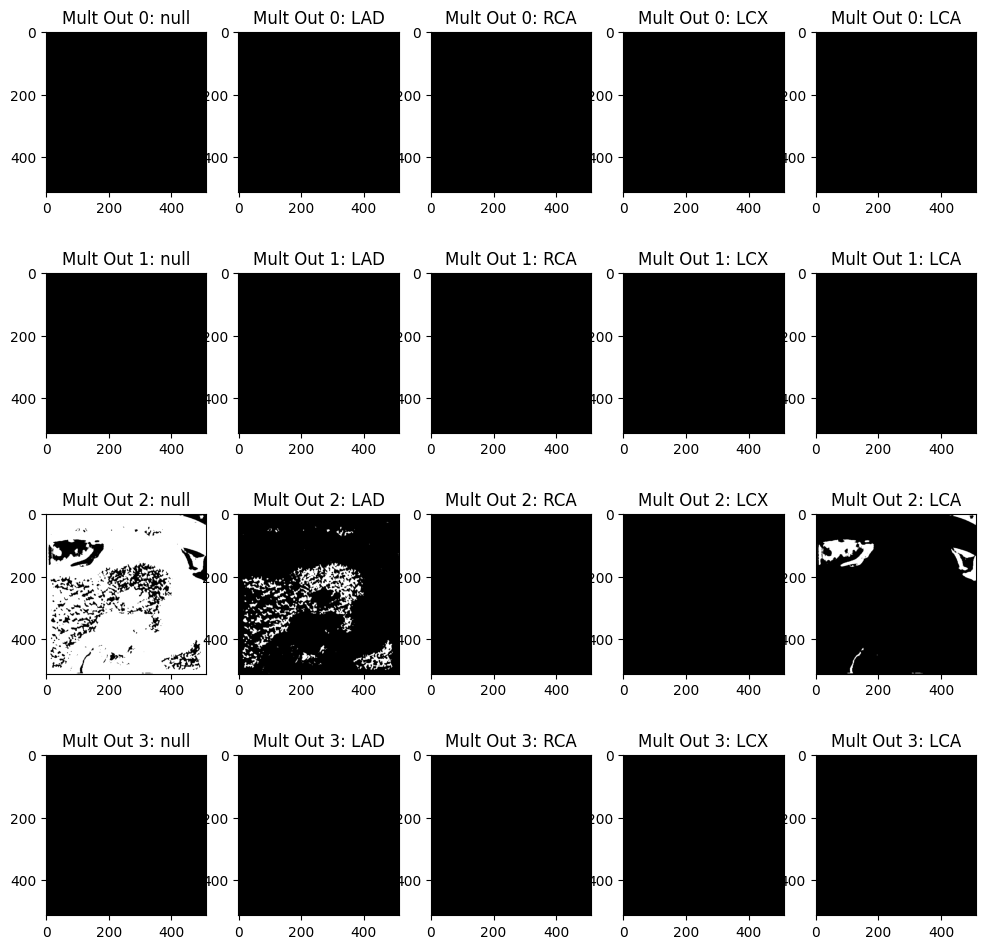

In [9]:
raw_mult_output = []
clipped_mult_output = []
mult_roi_coord = []
fig, ax = plt.subplots(4, 5, figsize=(12, 12))

for e, i in enumerate(range(4)):
    raw_mult_output.append(np.squeeze(float_output[i]))
    argmax = tf.argmax(raw_mult_output[e], axis=2)
    one_hot = tf.one_hot(argmax, depth=5, dtype=tf.float32)
    clipped_mult_output.append(one_hot)
    mult_roi_coord.append(np.where(clipped_mult_output[e] == 1))
    for pi, t in zip(range(5), ["null", "LAD", "RCA", "LCX", "LCA"]):
        ax[e][pi].set_title(f"Mult Out {e}: {t}")
        ax[e][pi].imshow(clipped_mult_output[e][:, :, pi], cmap="gray")
        print(e, t, np.sum(clipped_mult_output[e][:, :, pi]))

In [10]:
history = next((model_root_path).rglob("history.csv"))

In [11]:
df_history = pd.read_csv(history)
df_history

,epoch,loss,mult5_out_1_dice_coef,mult5_out_1_dice_coef_with_bg,mult5_out_1_loss,mult5_out_1_one_hot_mean_io_u,mult5_out_1_precision,mult5_out_1_recall,mult5_out_2_dice_coef,mult5_out_2_dice_coef_with_bg,...,val_mult5_out_3_loss,val_mult5_out_3_one_hot_mean_io_u,val_mult5_out_3_precision,val_mult5_out_3_recall,val_mult5_out_4_dice_coef,val_mult5_out_4_dice_coef_with_bg,val_mult5_out_4_loss,val_mult5_out_4_one_hot_mean_io_u,val_mult5_out_4_precision,val_mult5_out_4_recall
0,0,0.140506,0.000012,0.982153,0.033363,0.198512,0.994884,0.991106,0.000009,0.973215,...,0.001728,0.199907,0.999638,0.999458,2.240689e-06,0.999918,0.000214,0.199991,0.999958,0.999957
1,1,0.000739,0.000004,0.999939,0.000177,0.199993,0.999964,0.999964,0.000003,0.999935,...,0.023512,0.198486,0.994798,0.991705,7.604952e-07,0.999221,0.003059,0.199854,0.999369,0.999265
2,2,0.000632,0.000002,0.999961,0.000156,0.199993,0.999964,0.999964,0.000002,0.999960,...,0.306151,0.171446,0.957512,0.797232,1.635595e-06,0.999723,0.000378,0.199993,0.999968,0.999964


<Axes: xlabel='epoch'>

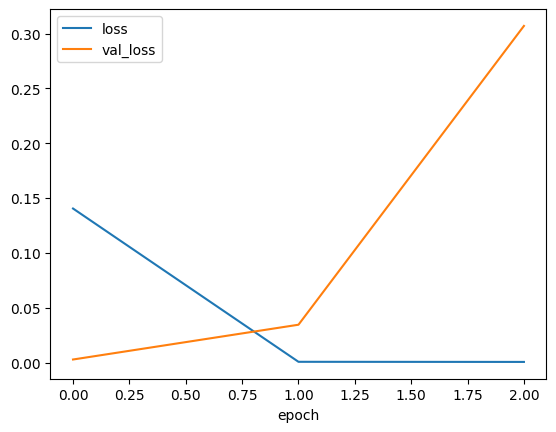

In [12]:
df_history.plot(x="epoch",y=["loss","val_loss"])

In [13]:
loss_list = []
mult_loss_list = []
bin_loss_list = []
val_loss_list = []
val_mult_loss_list = []
val_bin_loss_list = []
for col_name in list(df_history.columns):
    if "loss" in col_name:
        if "val" not in col_name:
            loss_list.append(col_name)
            if "bin" not in col_name:
                mult_loss_list.append(col_name)
            else:
                bin_loss_list.append(col_name)
        else:
            val_loss_list.append(col_name)
            if "bin" not in col_name:
                mult_loss_list.append(col_name)
            else:
                bin_loss_list.append(col_name)

<Axes: xlabel='epoch'>

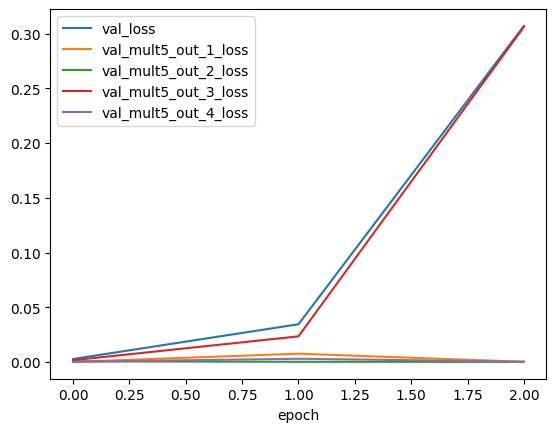

In [14]:
df_history.plot("epoch", val_loss_list)